In [9]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn import datasets 
data = datasets.load_iris() 
#create a DataFrame 
df = pd.DataFrame(data.data, columns=data.feature_names) 
df['Target'] = pd.DataFrame(data.target)
print(df.shape)
df.head()

(150, 5)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


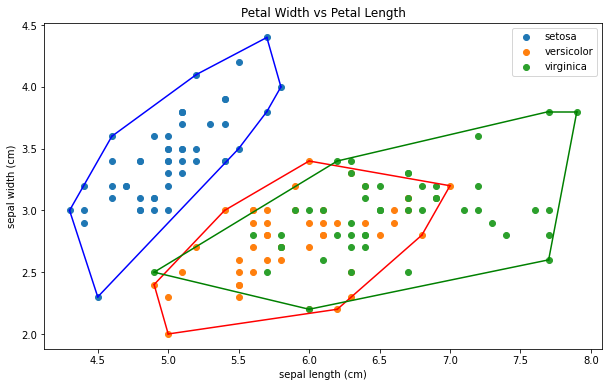

In [10]:
#visualisasi hasil ConvexHull
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from initHull import *
plt.figure(figsize = (10, 6))
colors = ['b','r','g']
plt.title('Petal Width vs Petal Length')
plt.xlabel(data.feature_names[0])
plt.ylabel(data.feature_names[1])
for i in range(len(data.target_names)):
    bucket = df[df['Target'] == i]              # untuk mengambil data dengan target yang seragam
    bucket = bucket.iloc[:,[0,1]].values        # untuk mendapatkan aray berupa posisi x dan y, berukuran n x 2, n adalah banyak datasort
    hull = ConvexHull(bucket)                  # bagian ini diganti dengan hasil implementasi ConvexHull Divide & Conquer
    # simplice = NewConvexHull(bucket)
    plt.scatter(bucket[:, 0], bucket[:, 1], label=data.target_names[i])
    for simplex in hull.simplices:
        plt.plot(bucket[simplex, 0], bucket[simplex, 1], colors[i])
plt.legend()

In [11]:
bucket = df[df['Target'] == 0]              # untuk mengambil data dengan target yang seragam
bucket = bucket.iloc[:,[0,1]].values


print(bucket[[0,1],:])

[[5.1 3.5]
 [4.9 3. ]]


[[0, 33], [33, 15], [15, 14], [14, 18], [18, 36], [36, 20], [20, 25], [25, 1], [1, 49], [0, 9], [9, 41], [41, 13], [13, 22], [22, 32], [32, 49]]
[5.1 3.5]
[4.6 3.2]
[5.  3.3]
[5.1 3.4]


C:\Users\user\AppData\Local\Temp/ipykernel_14468/2438148419.py:18: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(cosine)


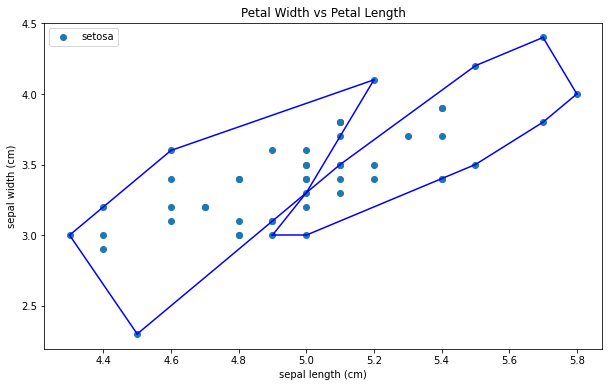

In [14]:
def DetFrom3Point(p1,p2,p3):
    mat = np.array([[1,1,1],
                    [p1[0],p2[0],p3[0]],
                    [p1[1],p2[1],p3[1]]])
    return np.linalg.det(mat)

def DistanceFromLine(p1,p2,p3):
    ''' Fungsi: Menerima 2 buah titik (p1 dan p2) yang membentuk segmen garis dan mengembalikan jarak dari p3 ke garis tsb
        Prekondisi : p1,p2,p3 adalah np.array 2 dimensi '''
    return np.cross(p2-p1,p3-p1)/np.linalg.norm(p2-p1)

def AngelFromLine(p1,p2,p3):
    ''' Fungsi: Menerima 2 buah titik (p1 dan p2) yang membentuk segmen garis p1p2 dan mengembalikan sudut p3p1p2
        Prekondisi : p1,p2,p3 adalah np.array 2 dimensi '''
    ba = p3 - p1
    bc = p2 - p1
    cosine = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    return np.arccos(cosine)

def NextSimplex(bucket,line,arr):             # UNTUK TAHAP KE-2 dst..
    ''' Proses: - Menerima himpunan titik pada suatu daerah yang ditandai oleh elemen array "arr" sebagai "indeks" dari array "bucket"
                - Array "bucket" memiliki elemen berupa titik secara universal
                - Array "line" memiliki elemen berupa "indeks" dari array "bucket" yang merupakan garis batas daerah sebelumnya
                - Fungsi akan mengembalikan simplex baru dari daerah tersebut
        Prekondisi : Daerah tersebut tidak kosong, minimal elemen array "arr" ada 1 '''
    
    ''' 1. Cari titik terjauh (p3) sehingga membentuk 2 buah line baru
           lineL adalah p1p3 berupa garis/ simplex sebelah KIRI
           lineR adalah p3p2 berupa garis/ simplex sebelah KANAN '''
    # a. Titik awal pada garis
    p1 = bucket[line[0]]
    
    # b. Titik akhir pada garis
    p2 = bucket[line[1]]
    
    d   = -1      # Jarak tidak mungkin negatif, inisiasi awal sebagai pembanding
    idx = -1      # Indeks ditemukannya titik dengan jarak terjauh   
    for i in arr:
        X = bucket[i,0]
        Y = bucket[i,1]
        p3 = np.array([X,Y])
        dTemp = DistanceFromLine(p1,p2,p3)
        if   (dTemp > d) :
            d   = dTemp
            idx = i
        elif ( dTemp==d ) :     # Jika jaraknya sama, makan bandingkan sudut
            dtheta    = AngelFromLine(p1,p2,p3)
            Temptheta = AngelFromLine(p1,p2,p3)
            if (Temptheta > dtheta) :
                d   = dTemp
                idx = i
        
    ''' 2. Setelah didapat titik terjauh, bentuk 2 buah line baru '''
    ### GARIS BAGIAN KIRI
    lineL = [line[0],idx]
    #   a. Titik awal pada garis
    p1L = bucket[lineL[0]]
    #   b. Titik akhir pada garis
    p2L = bucket[lineL[1]]
    
    ### GARIS BAGIAN KANAN
    lineR = [idx,line[1]]
    #   a. Titik awal pada garis
    p1R = bucket[lineR[0]]
    #   b. Titik akhir pada garis
    p2R = bucket[lineR[1]]
        
    ''' 3. Bagi kumpulan titik pada array "arr" menjadi 2 partisi, namun yg dipakai hanya partisi KIRI
        Apabila berada pada garis p1-p3, maka abaikan '''   
    arrL = []
    arrR = []
    ''' 3.1. Check di garis atau tidak untuk kedua garis batas baru, di garis (det=0) '''
    for i in arr:
        XX = bucket[i,0]
        YY = bucket[i,1]
        p3 = np.array([XX,YY])
        
        ''' 3.1.a. Check untuk bagian kiri lineL,
            3.1.b. Check untuk bagian kiri lineR,
            apabila (det>0) maka masukkan ke array selanjutnya untuk diperiksa '''
        detL = DetFrom3Point(p1L,p2L,p3)
        detR = DetFrom3Point(p1R,p2R,p3)
        if   (detL > 0) :
            arrL += [i]
        elif (detR > 0) :
            arrR += [i]        

    ''' 3.4 CONQUER & COMBINE masing-masing sisi (INI TAHAP TERSULIT)'''
    simplexL = []                            # {array simplex hanya menampung "pasangan" idx dari "adjecency" point}
    simplexR = []                            # {array simplex hanya menampung "pasangan" idx dari "adjecency" point}
    #  URUTAN CONQUER = KIRI -> KANAN
    # K-1 : Apabila kiri kosong
    if ( arrL==[] ) :
        simplexL += [lineL]
    else:
        simplexL += NextSimplex(bucket,lineL,arrL)
    if ( arrR==[] ) :
        simplexR += [lineR]
    else:
        simplexR += NextSimplex(bucket,lineR,arrR)
               
    return simplexL+simplexR


''' 2. Buat p1-pn sebagai line batas awal '''
line = [0,len(bucket)-1]
# a. Titik awal pada garis
p1   = bucket[line[0]]
# b. Titik akhir pada garis
p2   = bucket[line[1]]

''' 3. Bagi kumpulan titik yang lain menjadi 2 partisi
    Apabila berada pada garis p1-pn, maka abaikan '''
left  = []
right = []
''' 3.1. Check di garis atau tidak, di garis (det=0) '''
for i in range(len(bucket)):
    X = bucket[i,0]
    Y = bucket[i,1]
    p3 = np.array([X,Y])
    det = DetFrom3Point(p1,p2,p3)
    ''' 3.2 Jika tidak digaris, bagi menjadi bagian KIRI (det>0) dan KANAN (det<0) '''
    if   (det > 0) :
        left  += [i]
    elif (det < 0) :
        right += [i]

''' 3.4 DIVIDE & CONQUER & COMBINE masing-masing sisi (INI TAHAP TERSULIT) '''
simplex = []                                        # {array simplex hanya menampung "pasangan" idx dari "adjecency" point}
#  URUTAN CONQUER = KIRI -> KANAN
# K-1 : Apabila kiri kosong
if ( left==[] ) :
    # K-1.1 : Kanan kosong, maka simplex tetep
    if ( right==[] ) :
        simplex += [line]
    # K-1.2 : Kanan ada, maka simplex diubah menjadi bagian kanan
    else :
        simplex += [line]
        simplex += NextSimplex(bucket,line,right)
        
# K-2 : Apabila kiri ada, maka disimpan simpex batas, dan diubah menjadi bagian sebelah kiri
else :
    # K-2.1 : Kanan kosong, maka simplex diubah menjadi bagian kiri
    if ( right==[] ) :
        simplex += NextSimplex(bucket,line,left)
        simplex += [line]
    else :
        simplex += NextSimplex(bucket,line,left)
        simplex += NextSimplex(bucket,line,right)
        
print(simplex)
plt.figure(figsize = (10, 6))
colors = ['b','r','g']
plt.title('Petal Width vs Petal Length')
plt.xlabel(data.feature_names[0])
plt.ylabel(data.feature_names[1])
bucket = df[df['Target'] == 0]              # untuk mengambil data dengan target yang seragam
bucket = bucket.iloc[:,[0,1]].values        # untuk mendapatkan aray berupa posisi x dan y, berukuran n x 2, n adalah banyak datasort
# hull = ConvexHull(bucket)                   # bagian ini diganti dengan hasil implementasi ConvexHull Divide & Conquer

plt.scatter(bucket[:, 0], bucket[:, 1], label=data.target_names[0])
for simplec in simplex:
    plt.plot(bucket[simplec, 0], bucket[simplec, 1], colors[0])
plt.legend()